# Countercurrent reverse water-gas-shift
In this Jupyter notebook I outline the thermodynamic claculations used in figure 2 of the manuscript (add DOI). I use [cantera](https://cantera.org/) for equilibrium calculations. To rule out unwanted side reactions such as methane formation I modified the gri-3.0 database to remove unwanted species. The new database is [RWGS-database.cti](RWGS-database.cti). This also speeds up the calculation of equilibrium as there are less possible species and reactions. 

## Co-feeding reverse water-gas-shift
First let's calculate the thermodynamic equilibrium of the conventional reverse water-gas-shift reaction given by,
\begin{equation}
\mathrm{H_2 + CO_2 \rightarrow H_2O + CO}
\end{equation}
We can visualise the general thermodynamics of this reaction using an ellinham diagram as seen below. We see that the reaction equilibrium has a relativly weak dependence on temperature. This is because there is no change in the number of moles, and so the change in entropy of the reaction is not very large, with $\Delta G = \Delta H - T \Delta S$.


\Delta G becomes negative at T =  1097


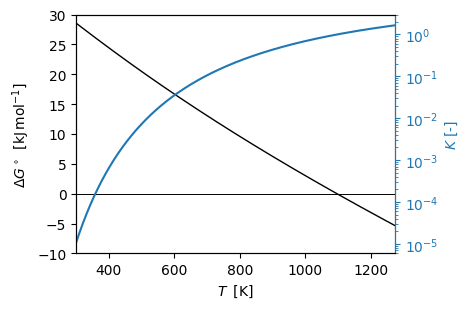

In [5]:
import cantera as ct
import numpy as np
import os
import matplotlib.pyplot as plt

T_range = np.arange(300, 1273, 1)

H2O = ct.Solution("RWGS-database.cti")
H2O.X = {"H2O":1 }

H2 = ct.Solution("RWGS-database.cti")
H2.X = {"H2":1 }

CO = ct.Solution("RWGS-database.cti")
CO.X = {"CO":1 }

CO2 = ct.Solution("RWGS-database.cti")
CO2.X = {"CO2":1 }

# make lists for the change in gibbs free energy and the equilibrium constant
dG = []
K = []
found = 0 # keep track of when the dG becomes negative
for T in T_range:
    H2O.TP = T, 100000
    H_H2O = H2O.enthalpy_mole/1000
    S_H2O = H2O.entropy_mole/1000
    H2.TP = T, 100000
    H_H2 = H2.enthalpy_mole/1000
    S_H2 = H2.entropy_mole/1000
    CO.TP = T, 100000
    H_CO = CO.enthalpy_mole/1000
    S_CO = CO.entropy_mole/1000
    CO2.TP = T, 100000
    H_CO2 = CO2.enthalpy_mole/1000
    S_CO2 = CO2.entropy_mole/1000
    dH_r = H_H2O + H_CO - H_H2 - H_CO2
    dS_r = S_H2O + S_CO - S_H2 - S_CO2
    dG_r = dH_r -T*dS_r
    dG.append(dG_r/1000)
    K_r = np.exp(-dG_r/(8.314*T))
    K.append(K_r)
    if found==0 and dG_r < 0:
        print("\Delta G becomes negative at T = ", T)
        found = 1

# plot the results of dG and K vs. T
xaxislabel = '$T\;\; \mathrm{[K]}$'
yaxislabel = "$\Delta G^\circ \; \; \mathrm{ [kJ \, mol^{-1}] }$"
y2axislabel = '$K$ [-]'
labels = [" $\mathrm{CO_2}$", "$\mathrm{H_2}$"]

fig = plt.figure(figsize=(4.8, 3.2), facecolor='white')
ax = plt.subplot()
ax.set_xlabel(xaxislabel)
ax.set_ylabel(yaxislabel)

axr = ax.twinx()
axr.spines['right'].set_color('C0')
axr.yaxis.label.set_color('C0')
axr.tick_params(axis = 'y', which = 'both', colors='C0')
axr.set_ylabel( y2axislabel )
axr.plot(T_range, K, color = 'C0')
axr.set_yscale('log')

ax.axhline(y=0, color = 'black', lw=0.7)
a, = ax.plot(T_range, dG, ls='-',  lw=1.0, color = 'black' , label=labels[0])
ax.set_xlim(300,1273)
ax.set_ylim(-10, 30)

plt.tight_layout()
plt.savefig(os.path.join('plots','ESI_dG' + '.png'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join('plots', 'ESI_dG' + '.pdf'), bbox_inches='tight')
plt.show()

Next we want to calculate the equilibrium conversion extent of CO$_2$ to CO, with varying temperature and the molar ratio of the feedstock H$_2$:CO$_2$. 


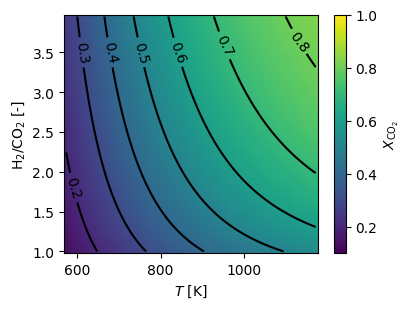

In [3]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import os

# define a solution object
RWGS = ct.Solution('RWGS-database.cti')

# Make arrays over which to calculate the CO2 conversion
nH2_range = np.arange(1.0,4.0,0.05)                 # [-] H2/CO2 = nH2
T_range = np.arange(573, 1183, 10)                  # [K]
p = 100000                                          # [Pa] or 1 bar

# make an 2D array to store the results
X_CO2_map = np.zeros((len(nH2_range), len(T_range)))

for i, n_H2 in enumerate(nH2_range):
    for j , T in enumerate(T_range):
        RWGS.X = {"H2": n_H2, "CO2": 1.0}
        RWGS.TP = T, p
        RWGS.equilibrate('TP')
        CO2_conversion = RWGS.X[RWGS.species_index('CO')]/(RWGS.X[RWGS.species_index('CO')]+ RWGS.X[RWGS.species_index('CO2')])
        X_CO2_map[i][j] = CO2_conversion

T_range, nH2_range  = np.meshgrid(T_range, nH2_range)

# Plot the results on a heatmap contour plot
fig = plt.figure(figsize=(4.2, 3.2), facecolor='white')
ax0 = plt.subplot()
ax0.set_xlabel('$T$ [K]')
ax0.set_ylabel('$\mathrm{H_2/CO_2}$ [-]')

im = ax0.pcolormesh(T_range, nH2_range, X_CO2_map, rasterized=True, vmin =0.1, vmax =1.0)
levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ct = ax0.contour(T_range, nH2_range, X_CO2_map, levels = levels, colors = 'black')
ax0.clabel(ct, fmt='%1.1f')
cb = fig.colorbar(im, ax=ax0)
cb.set_label(label ='$X_\mathrm{CO_2}$')
plt.tight_layout()
plt.savefig(os.path.join('plots',"figure_1c.png"), dpi = 400, bbox_inches='tight')
plt.savefig(os.path.join('plots',"figure_1c.pdf"), bbox_inches='tight')
plt.show()

## Countercurrent reverse water-gas-shift


In this section we calculate the thermodynamic limits on CO2 conversion for a hypothetical countercurrent oxygen exchange membrane reactor as illustrated.
<div>
<img src="figures/cc_membrane_reactor.png" width="500"/>
</div>
This countercurrent membrane case comprises two separate reaction steps which sum up to the RWGS reaction,
\begin{equation}
\label{eq2}
\mathrm{CO_2  \rightarrow CO + 0.5 O_2} \\
\end{equation}
\begin{equation}
\label{eq3}
\mathrm{H_2 + 0.5 O2 \rightarrow H_2O}.
\end{equation}
The oxygen produced by the CO$_2$ reduction reaction is transferred across the membrane to oxidise H$_2$ (\autoref{eq3}). In order to satisfy the conditions of thermodynamic spontaneity, the oxygen must move downhill in chemical potential. In other words the chemical potential of oxygen in the CO$_2$ flow, $\mu_\mathrm{O, \, CO_2}$, must be greater than or equal to that in the H$_2$ flow, $\mu_\mathrm{O,\, H_2}$,
\begin{equation}
\mu_\mathrm{O, \, CO_2}(x)  \geq \mu_\mathrm{O,\, H_2}(x)   
\label{eq09}
\end{equation}
at all points $x$ along a countercurrent reactor. This is illustrated in \autoref{fig1} \textbf{b} and \textbf{d}. This condition is used to calculate the thermodynamic limits according to a methodology developed in [previous work](https://doi.org/10.1039/C8CP07077F). On practice we use partial pressures of oxygen in place of the chemical potential. This is valid since the system is isothermal. 

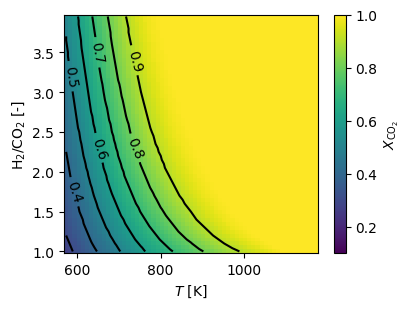

In [1]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import os

def maximum_CO2_conversion(T, p, nH2):
    """Determine the maximum conversion of CO2 for countercurrent flows of CO2 and H2 with
     flow rates of F_CO2 = 1, F_H2 = nH2, at temperature T [K], and presure p [Pa].
     kappa is the exchange coefficient which corresponds to the amount of exchanged O2.
     kappa = 0 means no reaction, kappa = 0.5 complete reaction.
     Paramaters
     -T   (temperature [K])
     -p   (pressure [Pa])
     -nH2 (hydrogen excess n_H2/n_CO2 [-])
     returns
     -X_CO2 (conversion extent of CO2 [-])"""
    # define the two flows as canter solution objects using cantera's gri30 database
    flow1 = ct.Solution('RWGS-database.cti')
    flow2 = ct.Solution('RWGS-database.cti')
    # Make arrays of the pO2(kappa) in each flow (note \mu_O2(p_O2))
    pO2_flow2 = []
    pO2_flow1 = []
    kappa_max = 0
    # complete conversion of CO2 to CO gives kappa = 0.5, kappa in range 0-0.5
    kappa_range = np.arange(0, 0.502, 0.002)
    for kappa in kappa_range:
        flow1.X = {'CO': 1, 'O2': 0.5 - kappa}
        flow2.X = {'H2': nH2, 'O2': kappa}
        flow1.TP = T, p
        flow2.TP = T, p
        flow1.equilibrate('TP')
        flow2.equilibrate('TP')
        pO2_f1 = flow1.X[flow1.species_index('O2')] * p
        pO2_f2 = flow2.X[flow2.species_index('O2')] * p
        # add the new pO2 values to the arrays
        pO2_flow1.append(pO2_f1)
        # for the second flow add pO2 value to the start of array to reverse kappa for countercurrent
        pO2_flow2.insert(0, pO2_f2)
        # if the arrays meet at any point, then the chemical potentials of oxygen are equal at that point
        # and we have reached the maximum exchange extent kappa_max
        if np.any(np.asarray(pO2_flow1) - np.asarray(pO2_flow2) <= 0) or kappa > 0.499:
            X_CO2 = 2 * kappa
            break
    return X_CO2


p = 100000 # Pa

# Make arrays over which to calculate the CO2 conversion
nH2_range = np.arange(1.0,4.0,0.05)                 # [-] H2/CO2 = nH2
T_range = np.arange(573, 1183, 10)                  # [K]
p = 100000                                          # [Pa] or 1 bar

# make an array to store the results
X_CO2_map = np.zeros((len(nH2_range), len(T_range)))
# run the calculations
for i, n_H2 in enumerate(nH2_range):
    #print("Progress: ", round(i*100 / len(nH2_range),3), " %")
    for j, T in enumerate(T_range):
        CO2_conversion = maximum_CO2_conversion(T, p, n_H2)
        X_CO2_map[i][j] = CO2_conversion


T_range, nH2_range  = np.meshgrid(T_range, nH2_range)

fig = plt.figure(figsize=(4.2, 3.2), facecolor='white')
ax0 = plt.subplot()
ax0.set_xlabel('$T$ [K]')
ax0.set_ylabel('$\mathrm{H_2/CO_2}$ [-]')
im = ax0.pcolormesh(T_range, nH2_range, X_CO2_map, rasterized=True, vmin =0.1, vmax =1.0)
levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ct = ax0.contour(T_range, nH2_range, X_CO2_map, levels = levels, colors = 'black')
ax0.clabel(ct, fmt='%1.1f')
cb = fig.colorbar(im, ax=ax0)
cb.set_label(label ='$X_\mathrm{CO_2}$')
#plt.title("")
#plt.plot(xCO2i, xCOi)
plt.tight_layout()
plt.savefig(os.path.join('plots',"figure_1f.png"), dpi = 400, bbox_inches='tight')
plt.savefig(os.path.join('plots',"figure_1f.pdf"), bbox_inches='tight')
plt.show()

# Calculation is slow. Save output for faster plot modification
np.savetxt('RWGS_Countercurrent_XCO2_map.csv', X_CO2_map, delimiter=",")

## Chemical poential profiles
Finally, to illustrate the difference in the co-feeding reaction and the countercurrent reaction we can plot the chemical poential profiles as a function of reaction extent.For the co-feed RWGS we visualize the oxygen chemical potential in CO$_2$ and H$_2$O for the two half reactions;
\begin{equation}
\label{eq2}
\mathrm{CO_2  \rightarrow CO + 0.5 O_2} \\
\end{equation}
\begin{equation}
\label{eq3}
\mathrm{H_2 + 0.5 O2 \rightarrow H_2O}.
\end{equation}
For each half reaction the oxygen chemical potential (or oxygen partial pressure) at a given temperature 
is fixed by the ratio (i) p_CO/p_CO2 and (ii) p_H2/p_H2O. when the oxygen chemical potential of these two half reactions
matches then the reaction has reached equilibrium.
For the countercurrent membrane reactor we calculate chemical potential as a function of exchanged oxygen for both half
reactions in countercurrent streams.

T, p =  1073 100000
O2, h, s, mu =  25264.268925713674 246.1641318655598 -238869.844566032


C:\Users\bulfinb\AppData\Local\Temp\ipykernel_16684\882382557.py:55: RuntimeWarning: divide by zero encountered in log
  mu_O_H2O = 0.5 * (R * T * np.log(pO2_H2O) + mu_O2) / 1000     # mu_O = 0.5(\mu_O2^\circ + RT ln(p_O2/p^\circ))


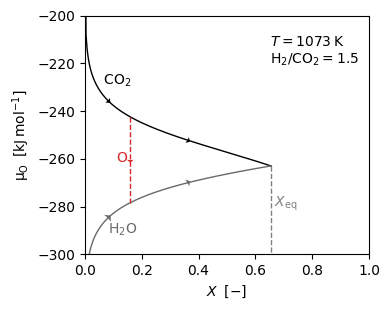

C:\Users\bulfinb\AppData\Local\Temp\ipykernel_16684\882382557.py:128: RuntimeWarning: divide by zero encountered in log
  mu_O_H2O = 0.5 * (R * T * np.log(pO2_H2O) + mu_O2) / 1000     # mu_O = 0.5(\mu_O2^\circ + RT ln(p_O2/p^\circ))


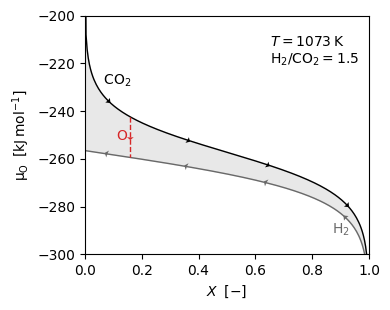

In [7]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import os

# set the process condtions
p = 100000 # Pa
T = 1073   # K
nH2 = 2.0  # H2/CO2
R = 8.314  # ideal gas constant

# get oxygen chemical potential at the reference pressure 1 bar
O2 = ct.Solution("RWGS-database.cti")
zeros = np.zeros(len(O2.X))
O2.X = zeros
O2.X = {"O2": 1.0}
O2.TP = T, p
h_O2 = O2.enthalpy_mole/1000    #1/1000 to get J/mol
s_O2 = O2.entropy_mole/1000
mu_O2 = h_O2 - s_O2*T           # O2 chemicalpotential at 1 bar and 1073 K
print("T, p = ", T, p)
print("O2, h, s, mu = ", h_O2, s_O2, mu_O2)


# COFEED figure 2b

# define solution objects for the half reactions
CO2 = ct.Solution('RWGS-database.cti')
H2O = ct.Solution('RWGS-database.cti')

# make lists to store the equilibrium oxygen partial pressure
pO2_CO2 = []
pO2_H2O = []
X_CO2 = np.arange(0, 1.004, 0.004)
for x in X_CO2:
    # iterates through CO2 conversion until partial pressures of the half reactions match
    CO2.X = {'CO': 1, 'O2': 0.5 - x/2}
    H2O.X = {'H2': 2.0, 'O2': x/2}
    CO2.TP = T, p
    H2O.TP = T, p
    CO2.equilibrate('TP')
    H2O.equilibrate('TP')
    pO2_1 = CO2.X[CO2.species_index('O2')] * p
    pO2_2 = H2O.X[H2O.species_index('O2')] * p
    pO2_CO2.append(pO2_1)
    pO2_H2O.append(pO2_2)
    if (pO2_2 > pO2_1 or x > 0.999):
        # we slightly overshoot equilibrium
        X_CO2_equilibrium = x
        break

# data for plotting
X = np.arange(0, X_CO2_equilibrium+0.004, 0.004)
mu_O_CO2 = 0.5 * (R * T * np.log(pO2_CO2) + mu_O2) / 1000    # mu_O = 0.5(\mu_O2^\circ + RT ln(p_O2/p^\circ))
mu_O_H2O = 0.5 * (R * T * np.log(pO2_H2O) + mu_O2) / 1000     # mu_O = 0.5(\mu_O2^\circ + RT ln(p_O2/p^\circ))

# plot the results
xaxislabel = '$X\;\; \mathrm{[-]}$'
yaxislabel = "$\mathrm{\mu_{\mathrm{O}}\; \; [kJ \, mol^{-1}]}$"
labels = [" $\mathrm{CO_2}$", "$\mathrm{H_2O}$"]

fig = plt.figure(figsize=(4.0, 3.2), facecolor='white')
ax = plt.subplot()
ax.set_xlabel(xaxislabel)
ax.set_ylabel(yaxislabel)
C1 = "black"
C2 = "dimgrey"

a, = ax.plot(X, mu_O_CO2, ls='-',  lw=1.0, color = C1 , label=labels[0])
# add arrows to the lines to indicate progression of the reaction
ax.quiver(X[20], mu_O_CO2[20], 1, -1, color=C1 , width=0.005, headwidth=8, scale =100)
ax.quiver(X[90], mu_O_CO2[90], 1, -0.6, color=C1 , width=0.005, headwidth=10, scale =100)

b, = ax.plot(X, mu_O_H2O, ls='-',  lw=1.0, color = C2, label=labels[1])
# add arrows to the lines to indicate progression of the reaction
ax.quiver(X[20], mu_O_H2O[20], 1, 1, color=C2, width=0.005, headwidth=12, scale =100)
ax.quiver(X[90], mu_O_H2O[90], 1, 0.6, color=C2, width=0.005, headwidth=12, scale =100)

# visualise the transfer of oxygen from CO2 to H2 and from higher to lower chemical potential
a, = ax.plot([X[40], X[40]], [mu_O_CO2[40],mu_O_H2O[40]], ls='--',  lw=1.0, color = 'C3' , label=labels[1])
ax.quiver(X[40], (mu_O_CO2[40]+mu_O_H2O[40])/2.0, 0, -1, color='C3', width=0.005, headwidth=12, scale =100)
ax.text(X[40]-0.05, (mu_O_CO2[40]+mu_O_H2O[40])/2.0 -1, '$\mathrm{O}$', color = 'C3')

# mark the equilibrium
a, = ax.plot([X.max()-0.002, X.max()-0.002], [mu_O_H2O.max(), -300.0], ls='--',  lw=1.0, color = 'grey')
ax.text(X.max()+0.01, -280.0, '$X_\mathrm{eq}$', color = 'grey')

# add some labels to the graph
ax.text(X[10]+0.01, mu_O_CO2[10], labels[0], color = C1)
ax.text(X[10]+0.04, mu_O_H2O[10], labels[1], color = C2)
ax.text(0.65, -220, '$T = 1073 \, \mathrm{K}$' + '\n' + '$\mathrm{H_2/CO_2} = 1.5$ ', color ="black")

ax.set_xlim(0,1)
ax.set_ylim(-300,-200)
plt.tight_layout()
plt.savefig(os.path.join('plots','figure_1b.png'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join('plots','figure_1b.pdf'), bbox_inches='tight')
plt.show()


# COUNTERCURRENT - figure 2e

# make lists to store the equilibrium oxygen partial pressure
pO2_CO2 = []
pO2_H2O = []
X_CO2 = np.arange(0, 1.004, 0.004)
for x in X_CO2:
    # iterates through CO2 conversion until partial pressures of the half reactions match
    CO2.X = {'CO': 1, 'O2': 0.5 - x/2}
    H2O.X = {'H2': 2.0, 'O2': x/2}
    CO2.TP = T, p
    H2O.TP = T, p
    CO2.equilibrate('TP')
    H2O.equilibrate('TP')
    pO2_1 = CO2.X[CO2.species_index('O2')] * p
    pO2_2 = H2O.X[H2O.species_index('O2')] * p
    pO2_CO2.append(pO2_1)
    pO2_H2O.insert(0, pO2_2)
    if np.any(np.asarray(pO2_CO2)-np.asarray(pO2_H2O) <= 0) or x > 0.999:
        # check if we reach equilibrium.
        # for the given conditions we reach full conversion
        X_CO2_equilibrium = x
        break

# data for plotting
X = np.arange(0, X_CO2_equilibrium+0.004, 0.004)
mu_O_CO2 = 0.5 * (R * T * np.log(pO2_CO2) + mu_O2) / 1000    # mu_O = 0.5(\mu_O2^\circ + RT ln(p_O2/p^\circ))
mu_O_H2O = 0.5 * (R * T * np.log(pO2_H2O) + mu_O2) / 1000     # mu_O = 0.5(\mu_O2^\circ + RT ln(p_O2/p^\circ))


# plot the results
xaxislabel = '$X\;\; \mathrm{[-]}$'
yaxislabel = "$\mathrm{\mu_{\mathrm{O}}\; \; [kJ \, mol^{-1}]}$"
labels = [" $\mathrm{CO_2}$", "$\mathrm{H_2}$"]

fig = plt.figure(figsize=(4.0, 3.2), facecolor='white')
ax = plt.subplot()
ax.set_xlabel(xaxislabel)
ax.set_ylabel(yaxislabel)
# colors
C1 = "black"
C2 = "dimgrey"

# shade between the lines to indicate range of chemical potentials that need to be stored in the packed bed
ax.fill_between(X, mu_O_H2O, mu_O_CO2, color = 'lightgrey', alpha=0.5)

a, = ax.plot(X, mu_O_CO2, ls='-',  lw=1.0, color = C1 , label=labels[0])
# add arrows to the lines to indicate progression of the reaction
ax.quiver(X[20], mu_O_CO2[20], 1, -1, color=C1 , width=0.005, headwidth=8, scale =100)
ax.quiver(X[90], mu_O_CO2[90], 1, -0.6, color=C1 , width=0.005, headwidth=10, scale =100)
ax.quiver(X[160], mu_O_CO2[160], 1, -0.6, color=C1 , width=0.005, headwidth=10, scale =100)
ax.quiver(X[230], mu_O_CO2[230], 1, -1, color=C1 , width=0.005, headwidth=8, scale =100)

b, = ax.plot(X, mu_O_H2O, ls='-',  lw=1.0, color = C2, label=labels[1])
# add arrows to the lines to indicate progression of the reaction
ax.quiver(X[20], mu_O_H2O[20], -1, 0.4, color=C2, width=0.005, headwidth=12, scale =100)
ax.quiver(X[90], mu_O_H2O[90], -1, 0.4, color=C2, width=0.005, headwidth=12, scale =100)
ax.quiver(X[160], mu_O_H2O[160], -1, 0.5, color=C2, width=0.005, headwidth=12, scale =100)
ax.quiver(X[230], mu_O_H2O[230], -1, 1, color=C2, width=0.005, headwidth=8, scale =100)

# visualise the transfer of oxygen from CO2 to H2 and from higher to lower chemical potential
a, = ax.plot([X[40], X[40]], [mu_O_CO2[40],mu_O_H2O[40]], ls='--',  lw=1.0, color = 'C3' , label=labels[1])
ax.quiver(X[40], (mu_O_CO2[40]+mu_O_H2O[40])/2.0, 0, -1, color='C3', width=0.005, headwidth=12, scale =100)
ax.text(X[40]-0.05, (mu_O_CO2[40]+mu_O_H2O[40])/2.0 -1, '$\mathrm{O}$', color = 'C3')

# add labels
ax.text(X[10]+0.01, mu_O_CO2[10], labels[0], color = C1)
ax.text(X[240]-0.09, mu_O_H2O[240], labels[1], color = C2)
ax.text(0.65, -220, '$T = 1073 \, \mathrm{K}$' + '\n' + '$\mathrm{H_2/CO_2} = 1.5$ ', color ="black")

ax.set_xlim(0,1)
ax.set_ylim(-300,-200)
plt.tight_layout()
plt.savefig(os.path.join('plots','figure_1e.png'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join('plots','figure_1e.pdf'), bbox_inches='tight')
plt.show()

We can also check the chemical potential of oxygen in ceria at 1073 K using an equilibrium model from [previous wrok](https://doi.org/10.1039/C6CP03158G).  

T, p =  1073 100000
O2, h, s, mu =  25264.268925713674 246.1641318655598 -238869.844566032


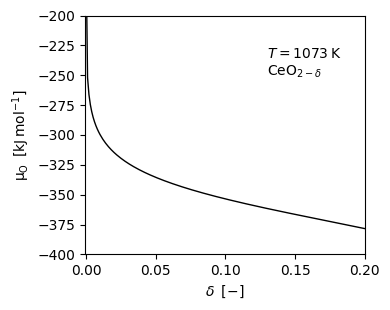

In [9]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import os

# set the process condtions
p = 100000 # Pa
T = 1073   # K
nH2 = 2.0  # H2/CO2
R = 8.314  # ideal gas constant

# get oxygen chemical potential at the reference pressure 1 bar
O2 = ct.Solution("RWGS-database.cti")
zeros = np.zeros(len(O2.X))
O2.X = zeros
O2.X = {"O2": 1.0}
O2.TP = T, p
h_O2 = O2.enthalpy_mole/1000    #1/1000 to get J/mol
s_O2 = O2.entropy_mole/1000
mu_O2 = h_O2 - s_O2*T           # O2 chemicalpotential at 1 bar and 1073 K
print("T, p = ", T, p)
print("O2, h, s, mu = ", h_O2, s_O2, mu_O2)



# Also calcultae and plot mu_O(delta) for CeO2
# CeO2 Thermodymics https://doi.org/10.1039/C6CP03158G  Eq 22 and 23 and table 1
dH = 430000   # [J mol^-1]
ds_th = 165   # J mol^-1 K^-1
d_m = 0.35    # -
n = 2.31      # -

def pO2(delta, T):
    """equilibrium oxygen partial pressure for CeO_2-delta at temperature T"""
    return 100000 * np.exp(2 * ds_th / R) * np.exp(-2 * dH / (R * T))  * ((d_m - delta) / delta) ** (2 * n)

def mu_O(delta, T):
    """equilibrium mu_O [kJ/mol]"""
    return 0.5 * ( mu_O2 + R * T * np.log( pO2(delta, T) /100000) ) / 1000.0

delta = np.arange(0.00001, 0.34101, 0.001)
mu_O_delta_1073 = mu_O(delta, 1073.0)

# plot mu_O vs delta at 1073 K
xaxislabel = '$\delta\;\; \mathrm{[-]}$'
yaxislabel = "$\mathrm{\mu_{\mathrm{O}}\; \; [kJ \, mol^{-1}]}$"

fig = plt.figure(figsize=(4.0, 3.2), facecolor='white')
ax = plt.subplot()
ax.set_xlabel(xaxislabel)
ax.set_ylabel(yaxislabel)
ax.plot(delta, mu_O_delta_1073, ls='-', color = 'black',  lw=1.0, label='1073')
ax.text(0.13, -250, '$T = 1073 \, \mathrm{K}$' + '\n' + '$\mathrm{CeO}_{2-\delta}$ ', color ="black")
ax.set_xlim(-0.001,0.2)
ax.set_ylim(-400,-200)
plt.tight_layout()
plt.savefig(os.path.join('plots','mu_O_vs_delta.png'), dpi=400, bbox_inches='tight')
plt.savefig(os.path.join('plots','mu_O_vs_delta.pdf'), bbox_inches='tight')
plt.show()